In [40]:
import keras

In [41]:
import tensorflow as tf
tf.__version__

'2.0.0'

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [42]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

/Users/xianhong/opt/anaconda3/envs/pizza/lib/python3.7/site-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/xianhong/opt/anaconda3/envs/pizza/lib/python3.7/site-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])



The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [43]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [44]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [45]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [46]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') 
                           for i in train_data[0]])

In [47]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparing the data - `One-hot-encoding`


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, 
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in 
detail later in the book).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [48]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [49]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels, which is straightforward:

In [50]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [51]:
y_train.shape

(25000,)

Now our data is ready to be fed into a neural network.

### Forward Propagation

In [106]:
from tensorflow.keras import models, layers
from keras import regularizers

model = models.Sequential()

model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

In [107]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 16)                160016    
_________________________________________________________________
batch_normalization_37 (Batc (None, 16)                64        
_________________________________________________________________
dropout_28 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 16)                272       
_________________________________________________________________
batch_normalization_38 (Batc (None, 16)                64        
_________________________________________________________________
dropout_29 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 4)               

The latter can be done by passing function objects as the `loss` or `metrics` arguments:

In [108]:
from tensorflow.keras import losses, metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validating our approach - `15000 Training Samples + 10000 Validating Samples`

**In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:**

In [81]:
data_train = np.concatenate([x_train, x_test])
data_label = np.concatenate([y_train, y_test])

x_train = data_train[:45000]
x_test = data_train[45000:]

y_train = data_label[:45000]
y_test = data_label[45000:]
'''
x_val = x_train[:5000]
partial_x_train = x_train[5000:]

y_val = y_train[:5000]
partial_y_train = y_train[5000:]
'''

'\nx_val = x_train[:5000]\npartial_x_train = x_train[5000:]\n\ny_val = y_train[:5000]\npartial_y_train = y_train[5000:]\n'

In [109]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_test, y_test))

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 6s 126us/sample - loss: 0.5634 - binary_accuracy: 0.7543 - val_loss: 0.5299 - val_binary_accuracy: 0.8876
Epoch 2/20
45000/45000 [==============================] - 4s 84us/sample - loss: 0.3948 - binary_accuracy: 0.8684 - val_loss: 0.3758 - val_binary_accuracy: 0.8940
Epoch 3/20
45000/45000 [==============================] - 4s 79us/sample - loss: 0.3323 - binary_accuracy: 0.8927 - val_loss: 0.3142 - val_binary_accuracy: 0.8974
Epoch 4/20
45000/45000 [==============================] - 4s 86us/sample - loss: 0.3007 - binary_accuracy: 0.9057 - val_loss: 0.3051 - val_binary_accuracy: 0.8948
Epoch 5/20
45000/45000 [==============================] - 4s 83us/sample - loss: 0.2809 - binary_accuracy: 0.9128 - val_loss: 0.3064 - val_binary_accuracy: 0.8976
Epoch 6/20
45000/45000 [==============================] - 4s 89us/sample - loss: 0.2698 - binary_accuracy: 0.9168 - val_loss: 0.3046 - 

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause 
as the model computes its loss and accuracy on the 10,000 samples of the validation data.

**Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data 
about everything that happened during training. Let's take a look at it:**

In [110]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the 
training and validation loss side by side, as well as the training and validation accuracy:

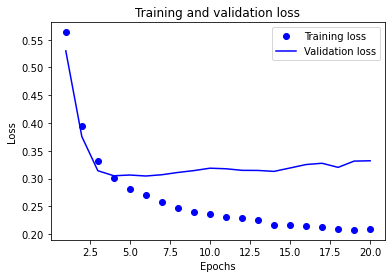

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['binary_accuracy']          # 原始程式：此處為 'acc' => 有誤！
val_acc = history.history['val_binary_accuracy']  # 原始程式：此處為 'val_acc'
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

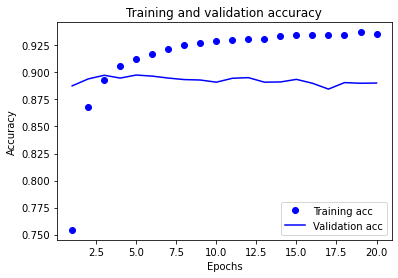

In [112]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']          # 原始程式：此處為 'acc' => 有誤！
val_acc_values = history_dict['val_binary_accuracy']  # 原始程式：此處為 'val_acc' => 有誤！

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [113]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test, verbose=2)

Train on 45000 samples
Epoch 1/4
45000/45000 [==============================] - 4s 82us/sample - loss: 0.3868 - accuracy: 0.8558
Epoch 2/4
45000/45000 [==============================] - 3s 61us/sample - loss: 0.2336 - accuracy: 0.9108
Epoch 3/4
45000/45000 [==============================] - 3s 63us/sample - loss: 0.1992 - accuracy: 0.9245
Epoch 4/4
45000/45000 [==============================] - 3s 62us/sample - loss: 0.1805 - accuracy: 0.9320
5000/1 - 0s - loss: 0.2283 - accuracy: 0.8944


In [114]:
results

[0.2746155172586441, 0.8944]

Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, one should be able to get close to 95%.

## Using a trained network to generate predictions on new data

After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive 
by using the `predict` method:

In [115]:
model.predict(x_test)

array([[0.00174263],
       [0.00172538],
       [0.9897685 ],
       ...,
       [0.07764393],
       [0.00956994],
       [0.27967796]], dtype=float32)

As you can see, the network is very confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4). 
